# Import packages

In [29]:
#%pip install datasets
#%pip install accelerate -U
#%pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import time
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from transformers import AutoTokenizer, DistilBertForSequenceClassification
import tensorflow as tf
import joblib
from sklearn.preprocessing import StandardScaler

# Load data

In [3]:
# Get all training data files
path = '../datasets/distilbert_data/train/'
files = [file for file in os.listdir(path) if file.endswith('text_clean.csv')]
files

['NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv',
 'EBIT_train__text_clean.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv',
 'NetIncomeLoss_train__text_clean.csv',
 'EarningsPerShareDiluted_train__text_clean.csv']

In [4]:
# Get all training data files
fb_path = '../datasets/finbert_data/train/'
fb_files = [file for file in os.listdir(fb_path) if file.endswith('text_clean.csv')]
fb_files

['NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv',
 'EBIT_train__text_clean.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv',
 'NetIncomeLoss_train__text_clean.csv',
 'EarningsPerShareDiluted_train__text_clean.csv']

In [12]:
# Load first data
df = pd.read_csv(path + files[0])
df.head()

,text,item,cik,year,val
0,Management considers several factors in assess...,item_7,922224,2020,5429000000
1,We estimate the fair values of the assets acqu...,item_7,1020569,2020,4147270000
2,If actual future taxable income differs from o...,item_7,1050915,2016,7651319000
3,The Company expects that it will be subject to...,item_7,29905,2017,6820886000
4,If all of our accumulated unrepatriated Indian...,item_7,1058290,2019,16783000000


In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


# Initialize model and tokenizer

In [5]:
model = DistilBertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain', num_labels = 1)
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.4.attention.q_lin.weight', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.10.attention.v_lin.weight', 'transformer.layer.3.ffn.lin1.bias', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.11.ffn.lin1.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.6.ou

# Tokenize text and prepare labeled datasets

In [7]:
def prepare_labeled_datasets(tokenizer, model, length, texts, labelsset):
  inputs=[]
  labels=[]
  for i in range(len(labelsset)):
    input=torch.tensor([tokenizer.encode(texts[i], padding='max_length',truncation=True, max_length=length)]).to(device) # Apply the tokenizer to get the token ids for each text, transform to tensors and send to GPU device
    label= torch.tensor([labelsset[i]]).to(device) # send the labels to the GPU device
    inputs.append(input)
    labels.append(label)
  inputs=torch.cat(inputs)  # add to the list of tensors
  labels=torch.cat(labels)  
  dataset = TensorDataset(inputs, labels) # Generate a labeled Tensor-Dataset for training
  return dataset

# Train models

In [8]:
def finbert_regressor():
    # Function to load the model and tokenizer of FinBERT
    model = DistilBertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain', num_labels = 1)
    tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')
    return model, tokenizer

### Finbert regressor

In [9]:
def loss_function(predictions, labels):
    # Define the loss function for the model 
    # Takes in the predictions and labels and 
    # returns the loss
    mse_predictions_labels = torch.nn.functional.mse_loss(predictions.view(-1), labels.view(-1).float())
    mean_labels = torch.mean(labels.float())
    mse_labels_mean = torch.nn.functional.mse_loss(labels.view(-1).float(), mean_labels.expand_as(labels).view(-1))
    rse = mse_predictions_labels / mse_labels_mean
    return rse

In [11]:
def train_finbert_regressor(model, tokenizer, dataset, epochs=10, initial_lr=2e-5, batch_size=32, cv=10, patience=3):
    # Function to train finbert regressor takes the following parameters as input:
        # model: finbert_regressor defined above
        # tokenizer: finbert tokenizer
        # dataset: dataset to train on
        # epochs: number of epochs to train for
        # initial_lr: initial learning rate
        # batch_size: batch size
        # cv: number of folds for cross validation
        # patience: number of epochs to wait for early stopping
    # Returns the best model, best validation loss, best fold, all training losses, all validation losses and training stats 
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr)
    
    training_stats = []
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)  # Define the number of folds
    
    best_val_loss_overall = np.inf # Set initial best validation loss to infinity
    best_model_overall = None
    best_epoch_overall = 0
    best_fold_overall = 0
    all_train_losses = []
    all_val_losses = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        #print(f"Fold {fold + 1}")
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

        best_val_loss = np.inf
        train_losses = []
        val_losses = []
        best_epoch = 0
        early_stopping_counter = 0
        for epoch in range(epochs):
            model.train()
            train_loss = 0

            for step, batch in enumerate(train_loader):
                b_input_ids = batch[0].to(device)
                b_labels = batch[1].to(device)
                optimizer.zero_grad()
                b_outputs = model(input_ids=b_input_ids, labels=b_labels)[1] # Prepare outputs for loss function
                loss = loss_function(b_outputs, b_labels) # Calculate loss (RSE)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            with torch.no_grad():
                val_loss = 0

                for batch in val_loader:
                    input_ids, labels = batch
                    input_ids.to(device)
                    labels.to(device)

                    outputs = model(input_ids=input_ids, labels=labels)
                    # Caclulate loss (RSE)
                    loss = loss_function(outputs[1], labels)
                    val_loss += loss.item()

                avg_val_loss = val_loss / len(val_loader)
                val_losses.append(avg_val_loss)
                
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_epoch = epoch + 1
                    early_stopping_counter = 0
                    best_fold = fold + 1
                    best_model = model
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= patience:
                        #print(f"Early stopping at epoch {epoch + 1} in fold {fold + 1}")
                        break
            
            

            training_stats.append({
                'Fold': fold + 1,
                'Epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
            })
        #print(f"Fold {fold + 1} - Best Validation Loss: {best_val_loss} at Epoch: {best_epoch}")
    
        # Save losses and model for this fold
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        
        # Save the best model for this fold
        if best_val_loss < best_val_loss_overall:
            best_val_loss_overall = best_val_loss
            best_model_overall = best_model
            best_epoch_overall = best_epoch
            best_fold_overall = best_fold
    return best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats

In [12]:
# Plot the learning curve from training_stats, filtered by fold
def plot_learning_curve(training_stats, fold):
    df = pd.DataFrame(training_stats)
    df = df[df['Fold'] == fold]
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df['Epoch'], df['Training Loss'], label='Training Loss')
    ax.plot(df['Epoch'], df['Valid. Loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Learning Curve (Fold {fold})')
    ax.legend()
    plt.show()

### CV on all DistilBERT data



--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 4
Best validation RSE: 0.97
Time: 31.16 seconds


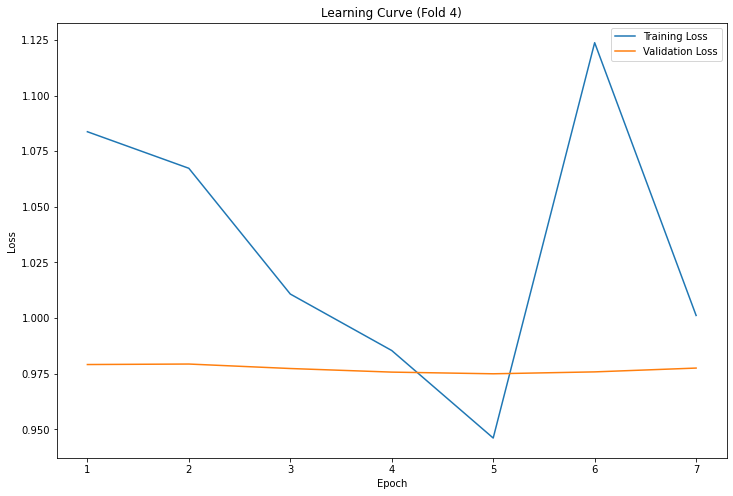

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]



--------------START TRAINING MODEL FOR EBIT--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 2
Best validation RSE: 1.02
Time: 204.29 seconds


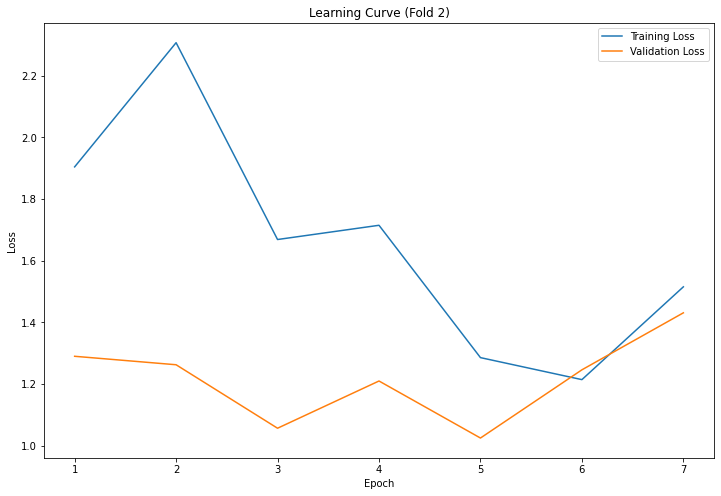

--------------DONE TRAINING MODEL FOR EBIT--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]



--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 0
Best validation RSE: inf
Time: 12.52 seconds


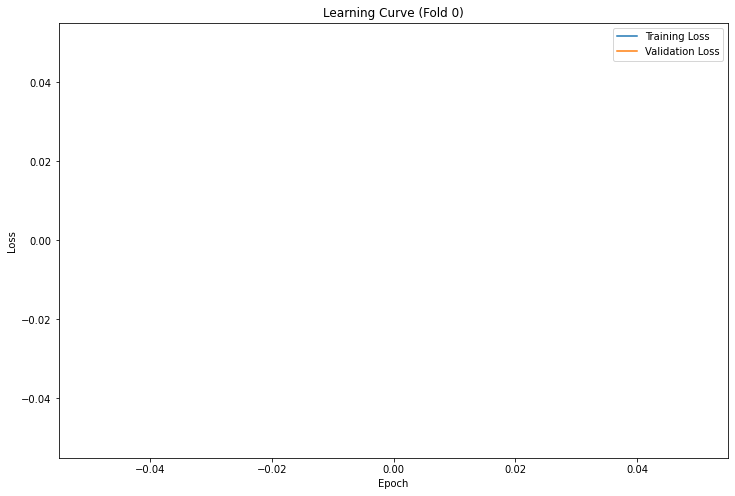

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


No model available


--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 3
Best validation RSE: 0.28
Time: 7865.02 seconds


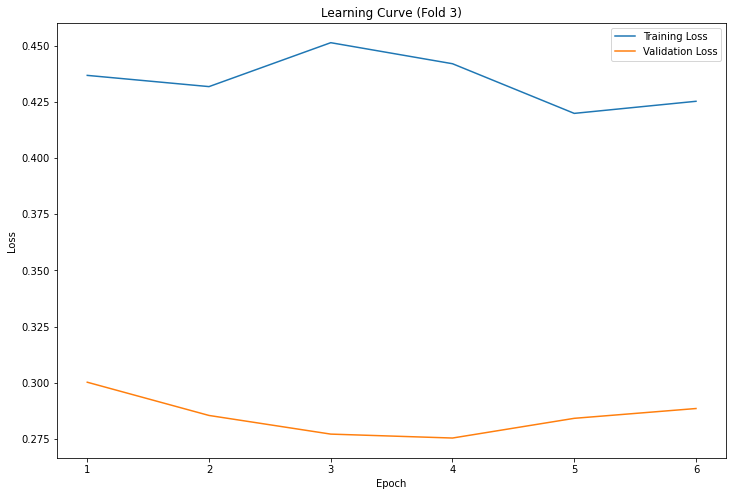

--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]



--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 9
Best validation RSE: 0.24
Time: 8346.07 seconds


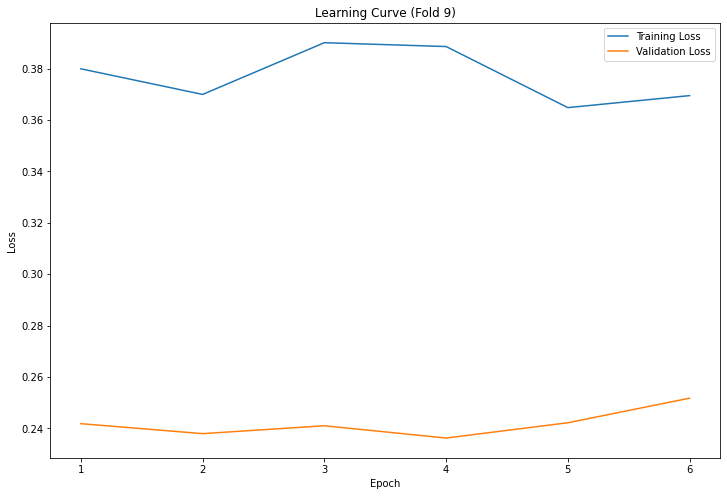

--------------DONE TRAINING MODEL FOR NetIncomeLoss--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]



--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.attention.q_lin.weight', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.8.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.8.attention.q_lin.weight', 'pre_classifier.weight', 'transformer.layer.9.ffn.lin2.bias', 'classifier.weight', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.4.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.

Results from the best model
Fold with best validation RSE: 7
Best validation RSE: 0.81
Time: 376.01 seconds


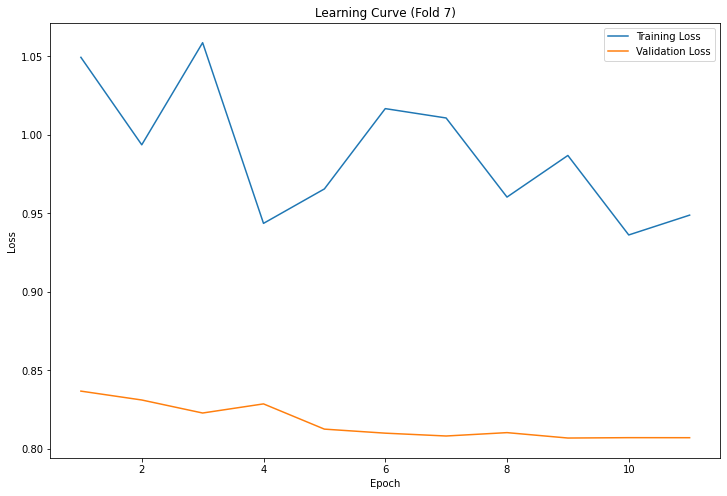

--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [50]:
for file in files: 
    metric_name = file.split('.')[0].split('_')[0]
    print('\n')
    print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")
    # Record time
    start_time = time.time()
    # Read csv file
    df = pd.read_csv(path + file)

    # Load model and tokenizer
    model, tokenizer = finbert_regressor()
    model.to(device)

    # Scale data
    scaler = StandardScaler()
    df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

    # Prepare dataset
    dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

    # Train model
    best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset)

    # Record time    
    training_time = time.time() - start_time

    # Present results from the best model
    print("Results from the best model")
    print(f"Fold with best validation RSE: {best_fold_overall}")
    print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 
    print("Time: {0:.2f} seconds".format(training_time))
    plot_learning_curve(training_stats,best_fold_overall)

    print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
    print("\n")

    # Save models
    # Check if model exists
    if best_model_overall is None:
        print("No model available")
    else:
        # Save models
        hub_path = 'lenguyen/' + 'distilbert_' + metric_name  
        model.push_to_hub(hub_path)
        tokenizer.push_to_hub(hub_path)
        
        # Save scaler locally
        joblib.dump(scaler, f'../models/distilbert_data/{metric_name}_scaler.pkl')


In [15]:
from huggingface_hub import notebook_login

notebook_login()

### CV on all FinBERT data

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 10
Best validation RSE: 0.99


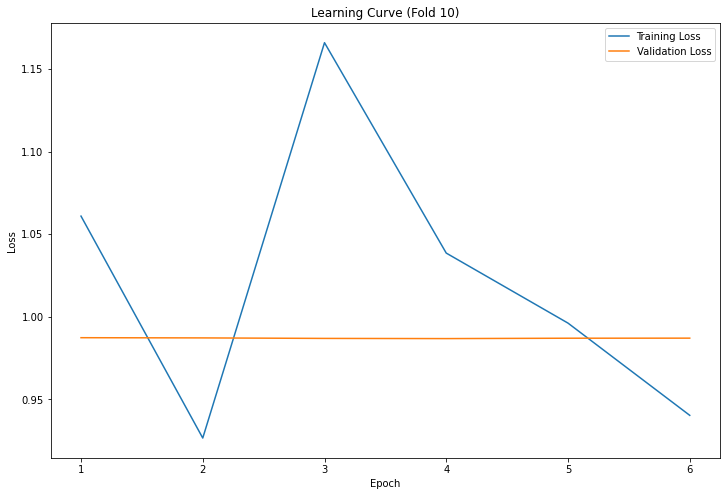

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

--------------START TRAINING MODEL FOR EBIT--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 3
Best validation RSE: 1.01


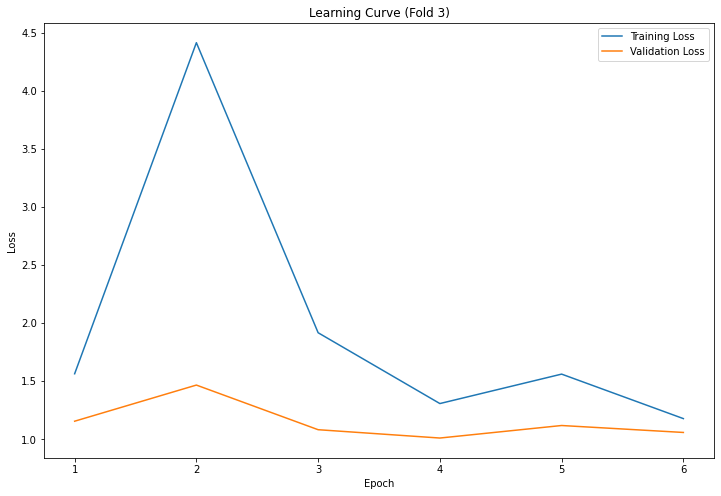

--------------DONE TRAINING MODEL FOR EBIT--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 3
Best validation RSE: 0.99


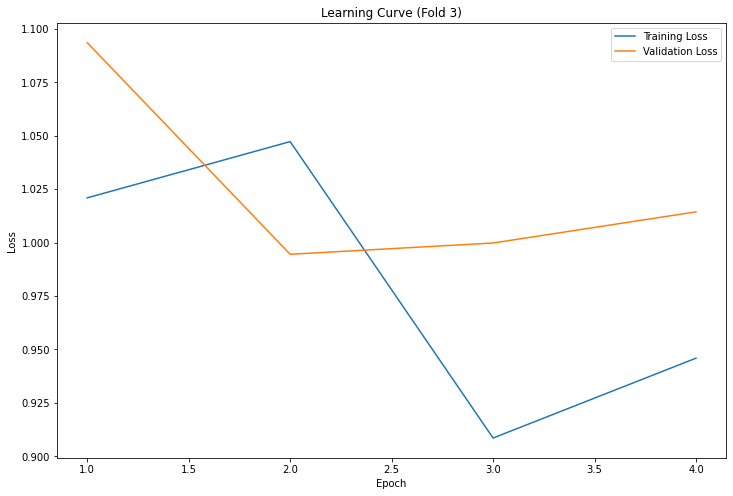

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 5
Best validation RSE: 0.23


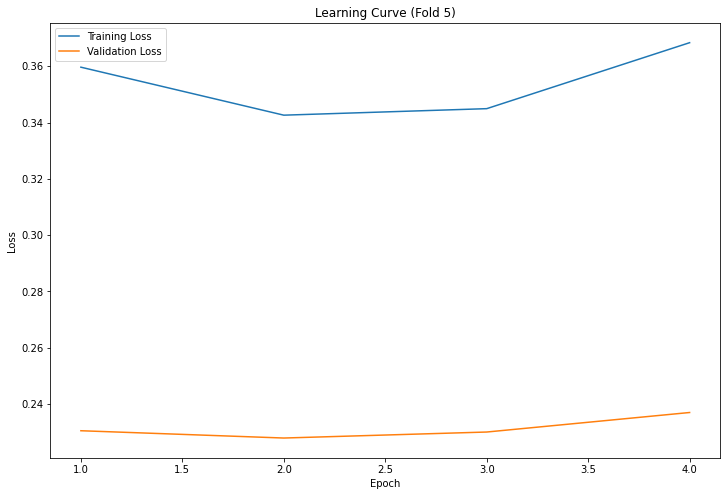

--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 5
Best validation RSE: 0.46


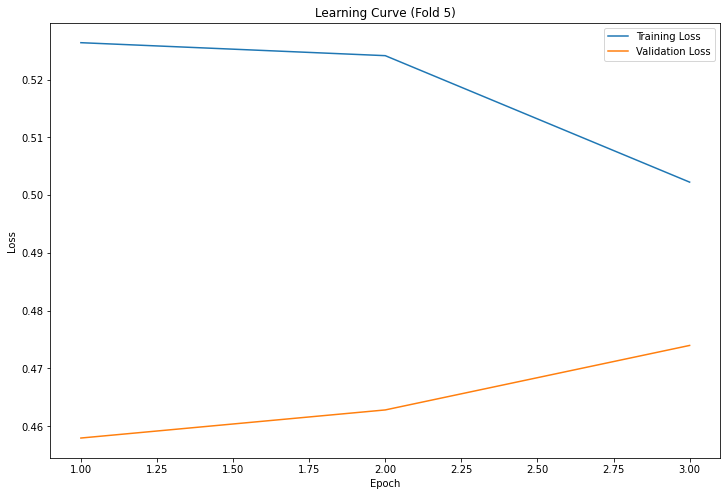

--------------DONE TRAINING MODEL FOR NetIncomeLoss--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.9.attention.k_lin.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.10.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.11.attention.out_lin.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.7.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.6.attention.k_lin.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.1.attention.out_lin.bias', 'transformer.layer.10

Results from the best model
Fold with best validation RSE: 8
Best validation RSE: 0.45


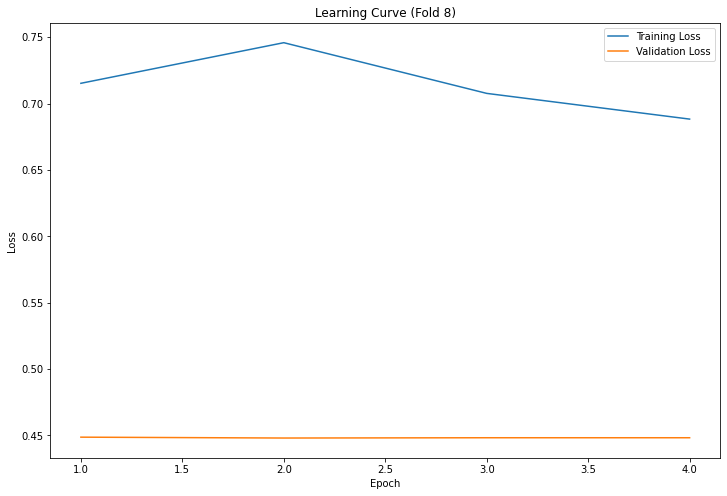

--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [16]:
for file in fb_files: 
    metric_name = file.split('.')[0].split('_')[0]

    print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

    # Read csv file
    df = pd.read_csv(fb_path + file)

    # Load model and tokenizer
    model, tokenizer = finbert_regressor()
    model.to(device)

    # Scale data
    scaler = StandardScaler()
    df['target'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))

    # Prepare dataset
    dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

    # Train model
    best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset)
    
    # Present results from the best model
    print("Results from the best model")
    print(f"Fold with best validation RSE: {best_fold_overall}")
    print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

    plot_learning_curve(training_stats,best_fold_overall)

    print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
    print("\n")

    # Save models
    # Check if model exists
    if best_model_overall is None:
        print("No model available")
    else:
        # Save models
        hub_path = 'lenguyen/' + 'finbert_' + metric_name  
        model.push_to_hub(hub_path)
        tokenizer.push_to_hub(hub_path)
        
        # Save scaler locally
        joblib.dump(scaler, f'../models/finbert_data/{metric_name}_scaler.pkl')
